# Electricity Load Forecasting for Maharashtra State

This project demonstrates the process of electricity load forecasting using various time series models. The steps include data preprocessing, exploratory data analysis (EDA), time series decomposition, and model fitting & forecasting, model cross-validation, residual diagnostics etc.

## Importing Libraries

We start by importing the necessary libraries.


In [30]:
# code to supress all warnings
import warnings
warnings.filterwarnings('ignore')

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from prophet import Prophet
import seaborn as sns
import statsmodels.api as sm


## Loading the Dataset

We load the electricity load data from an Excel file and perform basic preprocessing steps.


In [3]:
# Load the data
file_path = 'Data.xlsx'
data = pd.read_excel(file_path)
data.dropna(inplace=True)

# Data preprocessing
data.columns = ['Date', 'Electricity Load']
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m')
data.set_index('Date', inplace=True)

# Convert data to numeric, coerce errors to NaN
data['Electricity Load'] = pd.to_numeric(data['Electricity Load'], errors='coerce')

## Data Overview

We display basic information and descriptive statistics of the dataset.


In [4]:
# Describe the data
print("Data Info:")
print(data.info())
print("\nData Description:")
print(data.describe())
print("\nFirst few rows of the dataset:")
print(data.head())


Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2015-04-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Electricity Load  106 non-null    int64
dtypes: int64(1)
memory usage: 1.7 KB
None

Data Description:
       Electricity Load
count        106.000000
mean       22895.584906
std         3114.061057
min        16480.000000
25%        20569.500000
50%        22407.000000
75%        24515.250000
max        31178.000000

First few rows of the dataset:
            Electricity Load
Date                        
2015-04-01             20204
2015-05-01             20428
2015-06-01             19861
2015-07-01             20260
2015-08-01             19075


## Exploratory Data Analysis (EDA)

We perform basic EDA to understand the data better.




### Visualize the Data

We visualize the electricity load data to understand its trend over time.


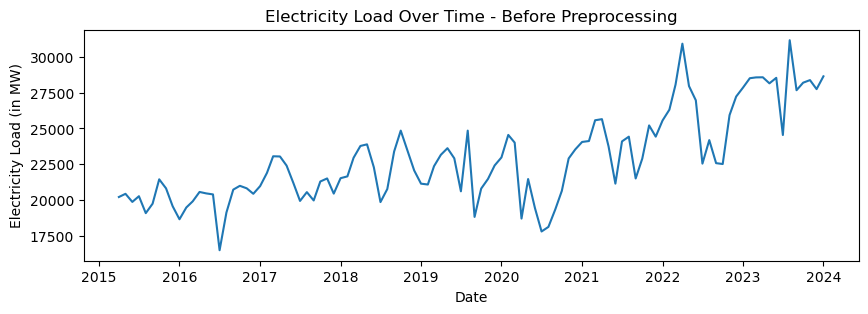

In [5]:
# Visualize the data before preprocessing
plt.figure(figsize=(10, 3))
plt.plot(data.index, data['Electricity Load'])
plt.title('Electricity Load Over Time - Before Preprocessing')
plt.xlabel('Date')
plt.ylabel('Electricity Load (in MW)')
plt.show()


## Preprocessing the data

### removing the NaN and infinite values

In [8]:
# Drop any rows with NaN values
data.dropna(inplace=True)

# Check for NaN or infinite values
if data.isna().sum().sum() > 0 or np.isinf(data).sum().sum() > 0:
    raise ValueError("The dataset contains NaN or infinite values. Please clean the dataset.")


### Handling Outliers

Outliers are removed by considering data points within 3 standard deviations from the mean.


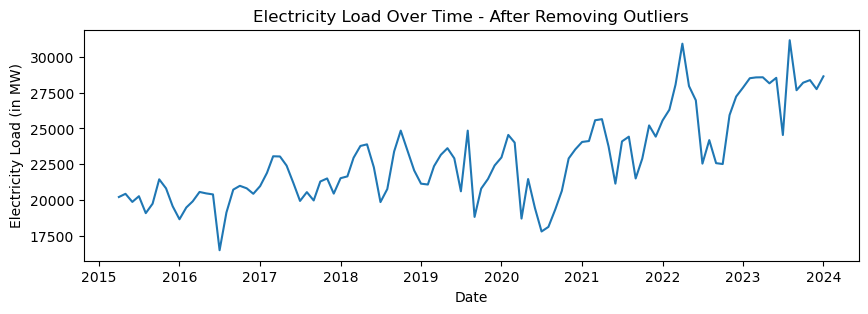

In [9]:
# Handling outliers: Remove data points beyond 3 standard deviations
data_cleaned = data[(np.abs(data['Electricity Load'] - data['Electricity Load'].mean()) <= (3 * data['Electricity Load'].std()))]

# Visualize the data after removing outliers
plt.figure(figsize=(10, 3))
plt.plot(data_cleaned.index, data_cleaned['Electricity Load'])
plt.title('Electricity Load Over Time - After Removing Outliers')
plt.xlabel('Date')
plt.ylabel('Electricity Load (in MW)')
plt.show()


### Box Plot

A box plot helps in identifying the distribution, central tendency, and potential outliers in the dataset.


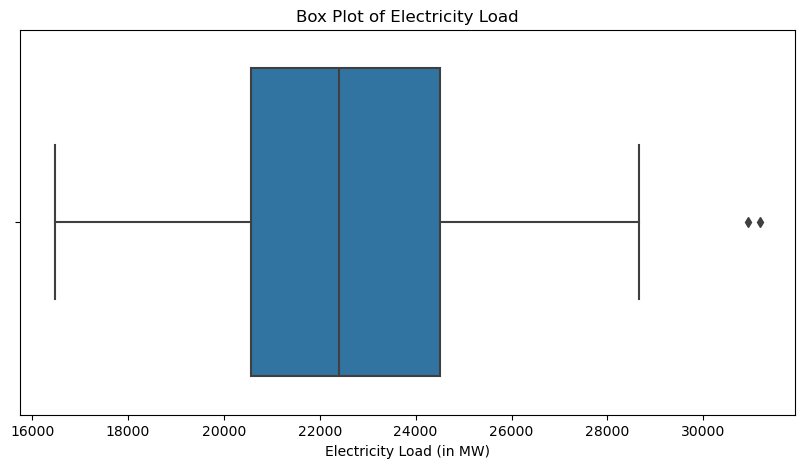

In [10]:
# Box plot for Electricity Load
plt.figure(figsize=(10, 5))
sns.boxplot(x=data_cleaned['Electricity Load'])
plt.title('Box Plot of Electricity Load')
plt.xlabel('Electricity Load (in MW)')
plt.show()


### Maximum and Minimum Values

Identifying the maximum and minimum values in the dataset helps in understanding the range and extreme values of the electricity load.


In [11]:
# Maximum and Minimum values
max_value = data_cleaned['Electricity Load'].max()
min_value = data_cleaned['Electricity Load'].min()
print(f"Maximum Electricity Load: {max_value} MW")
print(f"Minimum Electricity Load: {min_value} MW")


Maximum Electricity Load: 31178 MW
Minimum Electricity Load: 16480 MW


In [12]:
# Ensure there are enough data points for seasonal decomposition
if len(data_cleaned) < 24:  # At least 2 full seasonal cycles for better decomposition
    raise ValueError("The dataset does not contain enough data points for decomposition. At least 24 data points are recommended.")

# Perform basic EDA
print("\nBasic Exploratory Data Analysis (EDA):")
print("Descriptive Statistics:")
print(data_cleaned.describe())



Basic Exploratory Data Analysis (EDA):
Descriptive Statistics:
       Electricity Load
count        106.000000
mean       22895.584906
std         3114.061057
min        16480.000000
25%        20569.500000
50%        22407.000000
75%        24515.250000
max        31178.000000


## Time Series Analysis

We analyze the rolling statistics and perform the Dickey-Fuller test for stationarity.


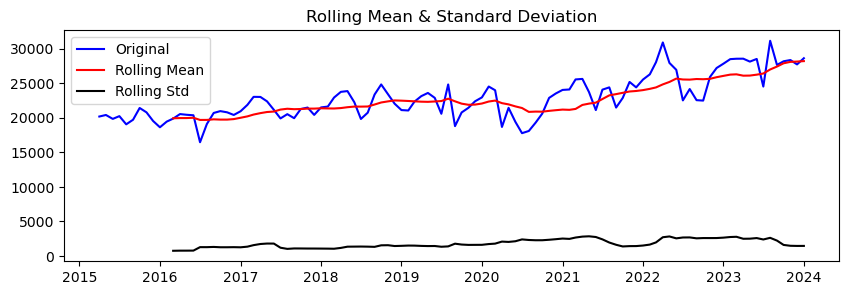


Results of Dickey-Fuller Test:
Test Statistic                  -2.192980
p-value                          0.208803
#Lags Used                       1.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


In [13]:
# Plotting rolling statistics
plt.figure(figsize=(10, 3))
rolling_mean = data_cleaned['Electricity Load'].rolling(window=12).mean()
rolling_std = data_cleaned['Electricity Load'].rolling(window=12).std()
plt.plot(data_cleaned.index, data_cleaned['Electricity Load'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

# Perform Dickey-Fuller test
print("\nResults of Dickey-Fuller Test:")
dftest = adfuller(data_cleaned['Electricity Load'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
print(dfoutput)


## Time Series Decomposition

We decompose the time series data into trend, seasonal, and residual components.


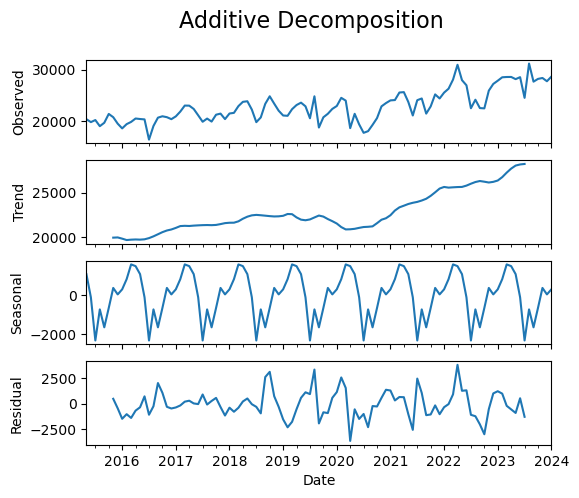

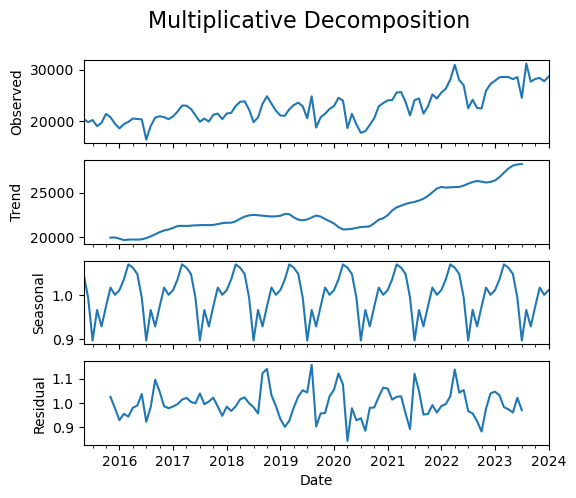

In [24]:
# Decomposition
try:
    result_mul = seasonal_decompose(data_cleaned['Electricity Load'], model='multiplicative', period=12)
    result_add = seasonal_decompose(data_cleaned['Electricity Load'], model='additive', period=12)

    # Plot additive decomposition
    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 5))
    result_add.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    result_add.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    result_add.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    result_add.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
    plt.suptitle('Additive Decomposition', fontsize=16)
    plt.show()

    # Plot multiplicative decomposition
    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 5))
    result_mul.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    result_mul.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    result_mul.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    result_mul.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
    plt.suptitle('Multiplicative Decomposition', fontsize=16)
    plt.show()

    

except ValueError as e:
    print(f"Decomposition error: {e}")
    # Handling the exception: providing feedback and ensuring the program continues to run
    df_reconstructed = None


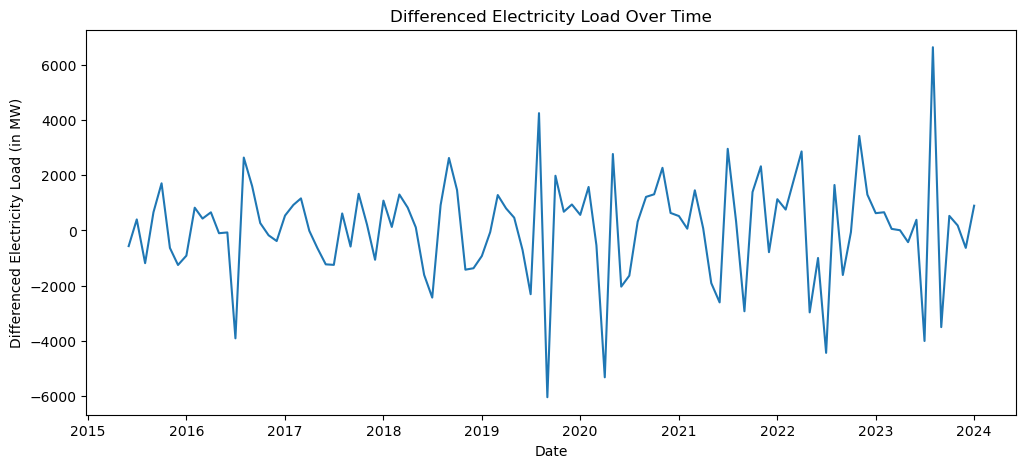


Results of Dickey-Fuller Test on Differenced Series:
Test Statistic                 -5.550789
p-value                         0.000002
#Lags Used                     10.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


In [25]:
# Differencing to remove the trend
data_cleaned['Electricity Load Diff'] = data_cleaned['Electricity Load'].diff().dropna()

# Drop NaN values resulted from differencing
data_cleaned.dropna(inplace=True)

# Plot the differenced series
plt.figure(figsize=(12, 5))
plt.plot(data_cleaned['Electricity Load Diff'])
plt.title('Differenced Electricity Load Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Electricity Load (in MW)')
plt.show()

# Perform Dickey-Fuller test on the differenced series
print("\nResults of Dickey-Fuller Test on Differenced Series:")
dftest_diff = adfuller(data_cleaned['Electricity Load Diff'], autolag='AIC')
dfoutput_diff = pd.Series(dftest_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest_diff[4].items():
    dfoutput_diff['Critical Value (%s)' % key] = value
print(dfoutput_diff)


## Model Fitting and Forecasting

We fit various time series models and forecast future electricity load.


C:\Users\itspr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itspr\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itspr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itspr\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
02:20:04 - cmdstanpy - INFO - Chain [1] start processing
02:20:05 - cmdstanpy - INFO - Chain [1] done processing


Forecast dates:
 DatetimeIndex(['2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31',
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31'],
              dtype='datetime64[ns]', freq='M')
Prophet forecast dates:
 0     2015-05-01
1     2015-06-01
2     2015-07-01
3     2015-08-01
4     2015-09-01
         ...    
112   2024-08-31
113   2024-09-30
114   2024-10-31
115   2024-11-30
116   2024-12-31
Name: ds, Length: 117, dtype: datetime64[ns]
Prophet forecast contains NaN values. Filling NaNs with the last observed value.


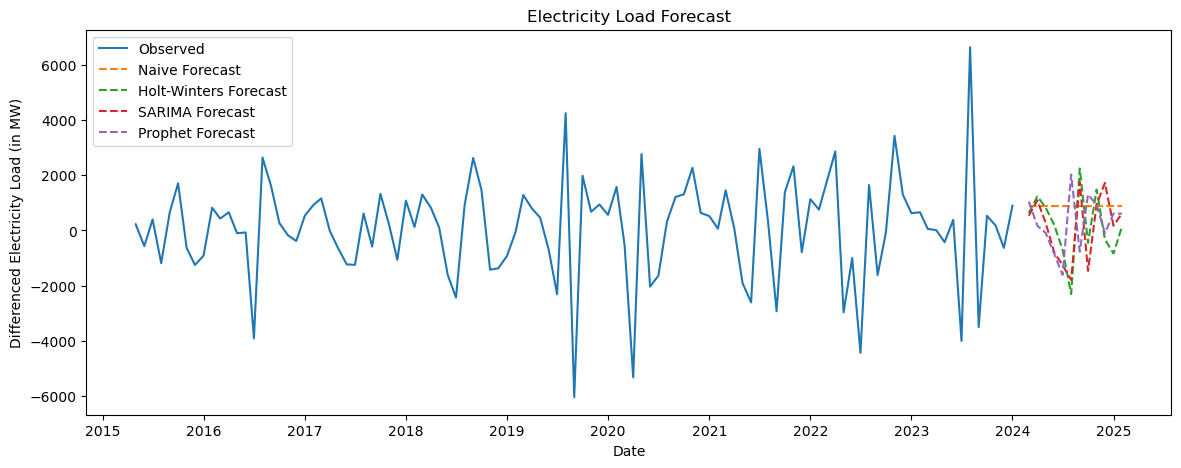

In [20]:

# Model fitting and forecasting
# Forecast dates
forecast_dates = pd.date_range(start=data_cleaned.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# Benchmark model: Naive method (Last observed value)
naive_forecast = np.full(12, data_cleaned['Electricity Load Diff'].iloc[-1])

# Holt-Winters Seasonal Model
model_hw = ExponentialSmoothing(data_cleaned['Electricity Load Diff'], trend='add', seasonal='add', seasonal_periods=12).fit()
forecast_hw = model_hw.forecast(12)

# SARIMA
model_sarima = SARIMAX(data_cleaned['Electricity Load Diff'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarima_fit = model_sarima.fit(disp=False)
forecast_sarima = model_sarima_fit.forecast(steps=12)

# Prophet Model
data_prophet = data_cleaned.reset_index().rename(columns={'Date': 'ds', 'Electricity Load Diff': 'y'})
model_prophet = Prophet()
model_prophet.fit(data_prophet)
future = model_prophet.make_future_dataframe(periods=12, freq='M')
forecast_prophet = model_prophet.predict(future)

# Debug: Print forecast dates and Prophet forecast dates
print("Forecast dates:\n", forecast_dates)
print("Prophet forecast dates:\n", forecast_prophet['ds'])

# Align Prophet forecast with forecast dates
forecast_prophet_sliced = forecast_prophet.set_index('ds').reindex(forecast_dates)['yhat']

# Check for NaN values in Prophet forecast and handle them
if forecast_prophet_sliced.isnull().any():
    print("Prophet forecast contains NaN values. Filling NaNs with the last observed value.")
    forecast_prophet_sliced = forecast_prophet_sliced.fillna(method='ffill').fillna(method='bfill')

# Combine univariate forecasts into a DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Naive': naive_forecast,
    'HoltWinters': forecast_hw.values,
    'SARIMA': forecast_sarima.values,
    'Prophet': forecast_prophet_sliced.values
}).set_index('Date')

# Plot all univariate forecasts
plt.figure(figsize=(14, 5))
plt.plot(data_cleaned.index, data_cleaned['Electricity Load Diff'], label='Observed')
plt.plot(forecast_df.index, forecast_df['Naive'], label='Naive Forecast', linestyle='--')
plt.plot(forecast_df.index, forecast_df['HoltWinters'], label='Holt-Winters Forecast', linestyle='--')
plt.plot(forecast_df.index, forecast_df['SARIMA'], label='SARIMA Forecast', linestyle='--')
plt.plot(forecast_df.index, forecast_df['Prophet'], label='Prophet Forecast', linestyle='--')
plt.title('Electricity Load Forecast')
plt.xlabel('Date')
plt.ylabel('Differenced Electricity Load (in MW)')
plt.legend()
plt.show()


## Model Evaluation

We evaluate the performance of each model using metrics such as RMSE, MAE, and MAPE.


In [21]:
# Model evaluation
# Assuming we have actual values for comparison for the forecast period
# Replace `actual_values` with actual data if available
actual_values = data_cleaned['Electricity Load Diff'][-12:].values  # Replace with actual data if available

# Ensure no NaN values in actual_values and forecast_df
if np.isnan(actual_values).any():
    raise ValueError("actual_values contains NaN values.")

# Evaluate univariate models
for model_name in ['Naive', 'HoltWinters', 'SARIMA', 'Prophet']:
    forecast_values = forecast_df[model_name].values
    if np.isnan(forecast_values).any():
        raise ValueError(f"Forecast values for {model_name} contain NaN values.")
    mae = mean_absolute_error(actual_values, forecast_values)
    mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100
    mse = mean_squared_error(actual_values, forecast_values)
    rmse = np.sqrt(mse)
    print(f"{model_name} Model Evaluation:")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}%")
    print(f"RMSE: {rmse}")
    print("\n")


Naive Model Evaluation:
MAE: 1786.4166666666667
MAPE: 1174.607726334171%
RMSE: 2626.322000440921


HoltWinters Model Evaluation:
MAE: 1271.8670097172455
MAPE: 1122.3278095526266%
RMSE: 1750.6623934661536


SARIMA Model Evaluation:
MAE: 1298.4750176837488
MAPE: 576.7350395603564%
RMSE: 1826.439021785731


Prophet Model Evaluation:
MAE: 1954.6607975542436
MAPE: 246.8204512632573%
RMSE: 3166.988571605294




## Cross-Validation and Residual Diagnostics

In this section, we perform cross-validation and residual diagnostics for each model to ensure the robustness and reliability of our forecasts.

### Cross-Validation for Naive Model

We use time series cross-validation with 5 splits to evaluate the Naive model.


In [22]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Initialize time series cross-validation with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Store the RMSE for each fold
naive_rmse_scores = []

# Perform cross-validation for the Naive model
for train_index, test_index in tscv.split(data_cleaned):
    cv_train, cv_test = data_cleaned.iloc[train_index], data_cleaned.iloc[test_index]

    # Naive forecast
    naive_forecast = np.full(len(cv_test), cv_train['Electricity Load Diff'].iloc[-1])

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(cv_test['Electricity Load Diff'], naive_forecast))
    naive_rmse_scores.append(rmse)

# Display cross-validation results
print("Naive Model Cross-Validated RMSEs:", naive_rmse_scores)
print("Naive Model Mean RMSE:", np.mean(naive_rmse_scores))


Naive Model Cross-Validated RMSEs: [1038.4602572474082, 2310.477274351366, 2498.3960384026154, 2668.2597986217866, 2682.2943756506406]
Naive Model Mean RMSE: 2239.5775488547633


### Residual Diagnostics for Naive Model

We analyze the residuals of the Naive model to check for any patterns that could indicate model inadequacy.


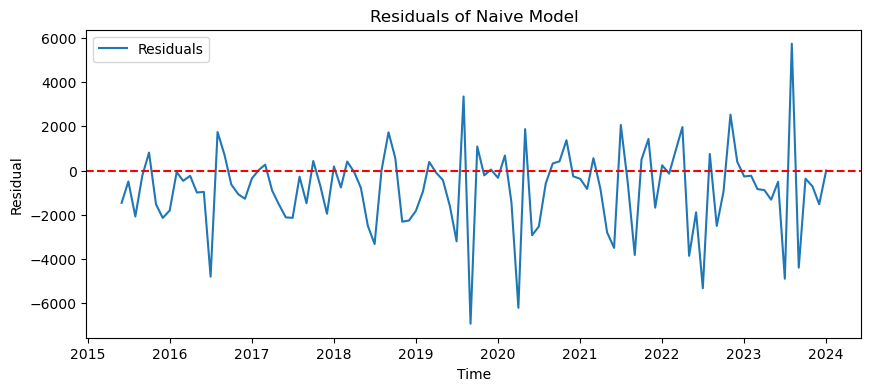

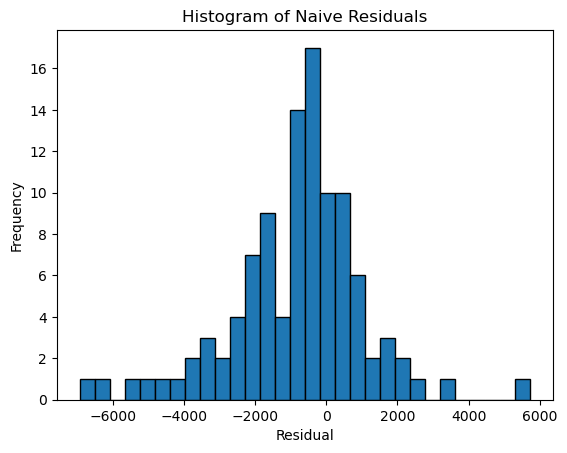

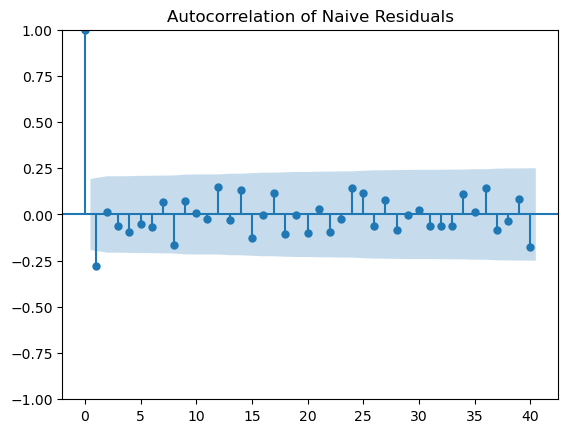

Naive Model Dickey-Fuller Test: ADF Statistic = -5.550788973201016
Naive Model Dickey-Fuller Test: p-value = 1.621626009281278e-06


In [28]:
# Fit the Naive model on the entire dataset
naive_forecast_full = np.full(len(data_cleaned), data_cleaned['Electricity Load Diff'].iloc[-1])
naive_residuals = data_cleaned['Electricity Load Diff'] - naive_forecast_full

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(naive_residuals, label='Residuals')
plt.title('Residuals of Naive Model')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.axhline(0, linestyle='--', color='red')
plt.legend()
plt.show()

# Histogram of residuals
plt.figure()
plt.hist(naive_residuals.dropna(), bins=30, edgecolor='k')
plt.title('Histogram of Naive Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# ACF plot of residuals
sm.graphics.tsa.plot_acf(naive_residuals.dropna(), lags=40)
plt.title('Autocorrelation of Naive Residuals')
plt.show()

# Conduct Dickey-Fuller test
result = adfuller(naive_residuals.dropna())
print("Naive Model Dickey-Fuller Test: ADF Statistic =", result[0])
print("Naive Model Dickey-Fuller Test: p-value =", result[1])



### Cross-Validation for Holt winters

We use time series cross-validation with 5 splits to evaluate the Exponential Smoothing model.


In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Store the RMSE for each fold
holt_winters_rmse_scores = []

# Perform cross-validation for the Holt-Winters model
for train_index, test_index in tscv.split(data_cleaned):
    cv_train, cv_test = data_cleaned.iloc[train_index], data_cleaned.iloc[test_index]

    # Check if there's enough data for seasonal estimation
    if len(cv_train) >= 24:  # ensuring at least two seasonal cycles
        model_hw = ExponentialSmoothing(cv_train['Electricity Load Diff'], trend='add', seasonal='add', seasonal_periods=12).fit()
        forecast_hw = model_hw.forecast(len(cv_test))
        rmse = np.sqrt(mean_squared_error(cv_test['Electricity Load Diff'], forecast_hw))
        holt_winters_rmse_scores.append(rmse)
    else:
        holt_winters_rmse_scores.append(np.nan)  # Use NaN to indicate insufficient data

# Display cross-validation results
print("Holt-Winters Model Cross-Validated RMSEs:", holt_winters_rmse_scores)
print("Holt-Winters Model Mean RMSE:", np.nanmean(holt_winters_rmse_scores))  # Using nanmean to ignore NaN values


Holt-Winters Model Cross-Validated RMSEs: [nan, 1973.3212227918734, 2027.916960108531, 2061.441781720848, 1832.9978423572409]
Holt-Winters Model Mean RMSE: 1973.9194517446235


### Residual Diagnostics for Exponential Smoothing Model

We analyze the residuals of the Exponential Smoothing model.


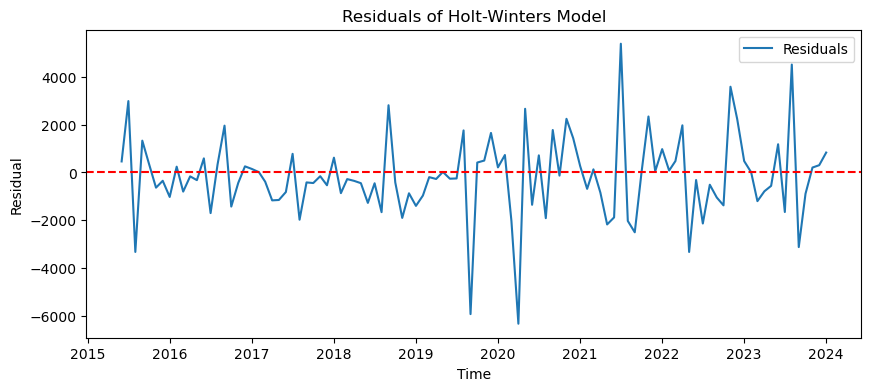

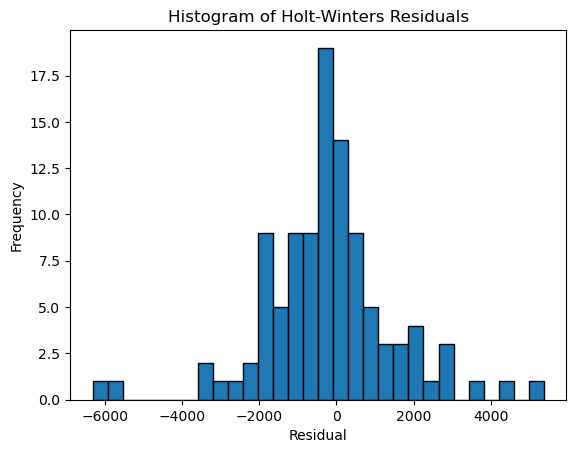

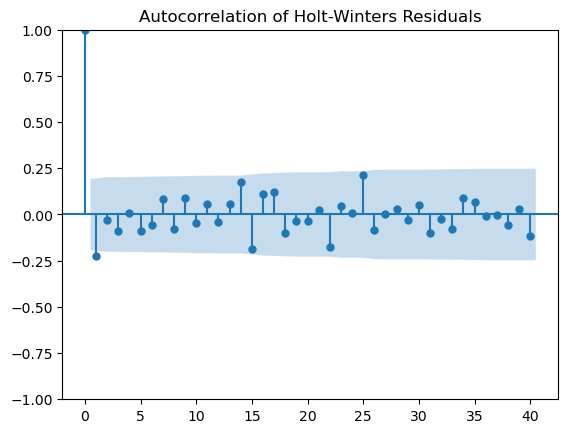

Holt-Winters Model Dickey-Fuller Test: ADF Statistic = -12.623698742417362
Holt-Winters Model Dickey-Fuller Test: p-value = 1.5581841870936834e-23


In [33]:
# Fit the Holt-Winters model on the entire dataset
if len(data_cleaned) >= 24:  # Ensure there's enough data for fitting
    model_hw_full = ExponentialSmoothing(data_cleaned['Electricity Load Diff'], trend='add', seasonal='add', seasonal_periods=12).fit()
    hw_residuals = data_cleaned['Electricity Load Diff'] - model_hw_full.fittedvalues

    # Plot residuals
    plt.figure(figsize=(10, 4))
    plt.plot(hw_residuals, label='Residuals')
    plt.title('Residuals of Holt-Winters Model')
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.axhline(0, linestyle='--', color='red')
    plt.legend()
    plt.show()

    # Histogram of residuals
    plt.figure()
    plt.hist(hw_residuals.dropna(), bins=30, edgecolor='k')
    plt.title('Histogram of Holt-Winters Residuals')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.show()

    # ACF plot of residuals
    sm.graphics.tsa.plot_acf(hw_residuals.dropna(), lags=40)
    plt.title('Autocorrelation of Holt-Winters Residuals')
    plt.show()

    # Conduct Dickey-Fuller test
    result = adfuller(hw_residuals.dropna())
    print("Holt-Winters Model Dickey-Fuller Test: ADF Statistic =", result[0])
    print("Holt-Winters Model Dickey-Fuller Test: p-value =", result[1])




### Cross-Validation for SARIMA Model

We use time series cross-validation with 5 splits to evaluate the SARIMA model.


In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Store the RMSE for each fold
sarima_rmse_scores = []

# Perform cross-validation for the SARIMA model
for train_index, test_index in tscv.split(data_cleaned):
    cv_train, cv_test = data_cleaned.iloc[train_index], data_cleaned.iloc[test_index]

    model_sarima = SARIMAX(cv_train['Electricity Load Diff'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=False)
    forecast_sarima = model_sarima.forecast(len(cv_test))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(cv_test['Electricity Load Diff'], forecast_sarima))
    sarima_rmse_scores.append(rmse)

# Display cross-validation results
print("SARIMA Model Cross-Validated RMSEs:", sarima_rmse_scores)
print("SARIMA Model Mean RMSE:", np.mean(sarima_rmse_scores))


SARIMA Model Cross-Validated RMSEs: [851.9739186376773, 2030.842864770923, 2010.4697123871388, 2453.3192128628575, 2048.349858927428]
SARIMA Model Mean RMSE: 1878.991113517205


### Residual Diagnostics for SARIMA Model

We analyze the residuals of the SARIMA model.


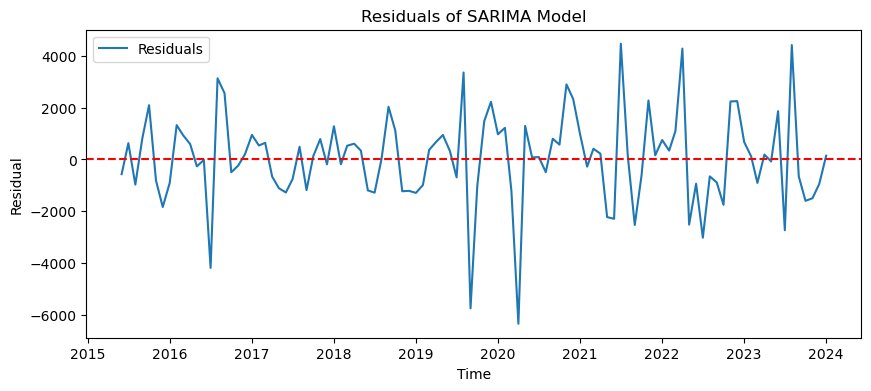

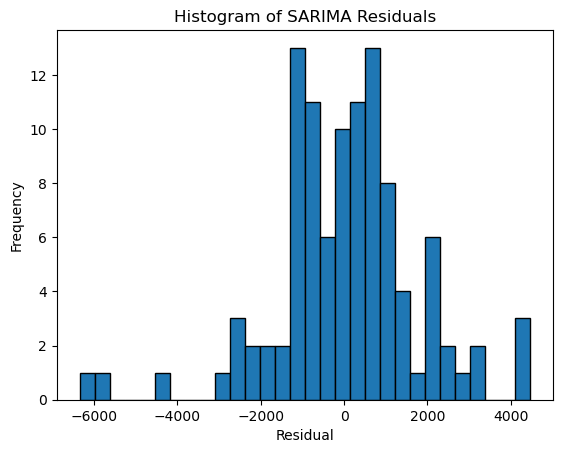

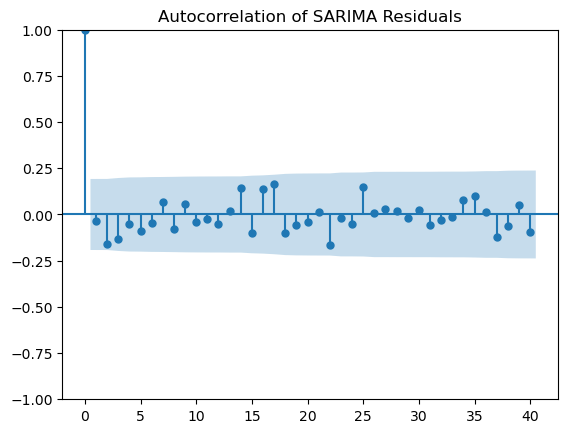

SARIMA Model Dickey-Fuller Test: ADF Statistic = -8.432658159234418
SARIMA Model Dickey-Fuller Test: p-value = 1.8521427025353937e-13


In [35]:
# Fit the SARIMA model on the entire dataset
model_sarima_full = SARIMAX(data_cleaned['Electricity Load Diff'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=False)
sarima_residuals = model_sarima_full.resid

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(sarima_residuals, label='Residuals')
plt.title('Residuals of SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.axhline(0, linestyle='--', color='red')
plt.legend()
plt.show()

# Histogram of residuals
plt.figure()
plt.hist(sarima_residuals.dropna(), bins=30, edgecolor='k')
plt.title('Histogram of SARIMA Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# ACF plot of residuals
sm.graphics.tsa.plot_acf(sarima_residuals.dropna(), lags=40)
plt.title('Autocorrelation of SARIMA Residuals')
plt.show()

# Conduct Dickey-Fuller test
result = adfuller(sarima_residuals.dropna())
print("SARIMA Model Dickey-Fuller Test: ADF Statistic =", result[0])
print("SARIMA Model Dickey-Fuller Test: p-value =", result[1])




### Cross-Validation for Prophet Model

We use time series cross-validation with 5 splits to evaluate the Prophet model.


In [36]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Initialize time series cross-validation with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Store the RMSE for each fold
prophet_rmse_scores = []

# Perform cross-validation for the Prophet model
for train_index, test_index in tscv.split(data_cleaned):
    cv_train, cv_test = data_cleaned.iloc[train_index], data_cleaned.iloc[test_index]

    # Prepare data for Prophet
    cv_train_prophet = cv_train.reset_index().rename(columns={'Date': 'ds', 'Electricity Load Diff': 'y'})
    cv_test_prophet = cv_test.reset_index().rename(columns={'Date': 'ds', 'Electricity Load Diff': 'y'})

    model_prophet = Prophet()
    model_prophet.fit(cv_train_prophet)

    future = model_prophet.make_future_dataframe(periods=len(cv_test), freq='M')
    forecast_prophet = model_prophet.predict(future)

    # Only take the forecasted values for the test period
    forecast_values = forecast_prophet['yhat'].iloc[-len(cv_test):].values

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(cv_test['Electricity Load Diff'], forecast_values))
    prophet_rmse_scores.append(rmse)

# Display cross-validation results
print("Prophet Model Cross-Validated RMSEs:", prophet_rmse_scores)
print("Prophet Model Mean RMSE:", np.mean(prophet_rmse_scores))


02:26:57 - cmdstanpy - INFO - Chain [1] start processing
02:26:57 - cmdstanpy - INFO - Chain [1] done processing
02:26:58 - cmdstanpy - INFO - Chain [1] start processing
02:26:58 - cmdstanpy - INFO - Chain [1] done processing
02:26:58 - cmdstanpy - INFO - Chain [1] start processing
02:26:59 - cmdstanpy - INFO - Chain [1] done processing
02:27:00 - cmdstanpy - INFO - Chain [1] start processing
02:27:00 - cmdstanpy - INFO - Chain [1] done processing
02:27:01 - cmdstanpy - INFO - Chain [1] start processing
02:27:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Cross-Validated RMSEs: [856.4395377252531, 4400.3189727475665, 2334.6326670460157, 1840.8626361185861, 2985.032021188007]
Prophet Model Mean RMSE: 2483.4571669650854


### Residual Diagnostics for Prophet Model

We analyze the residuals of the Prophet model.


02:27:18 - cmdstanpy - INFO - Chain [1] start processing
02:27:18 - cmdstanpy - INFO - Chain [1] done processing


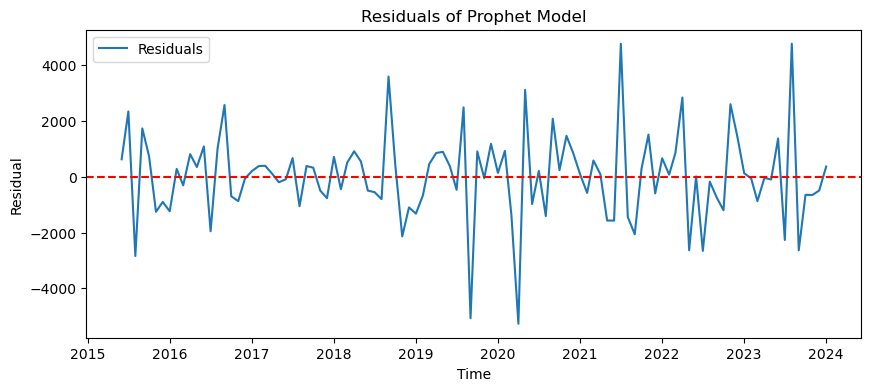

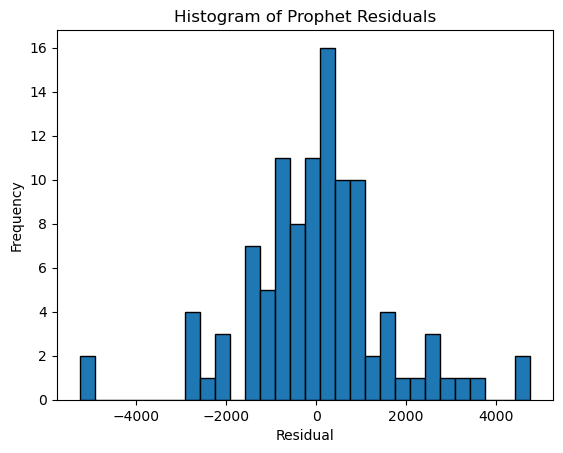

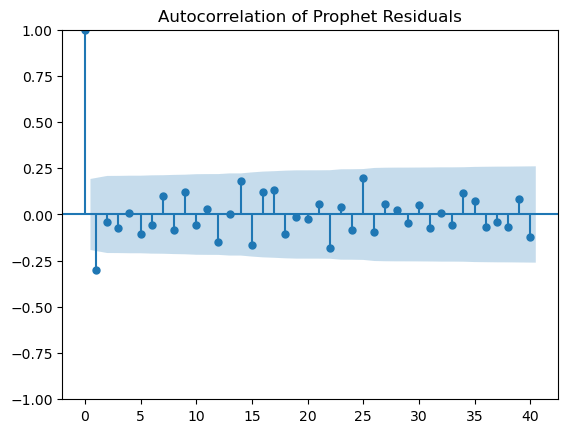

Prophet Model Dickey-Fuller Test: ADF Statistic = -6.534695982857837
Prophet Model Dickey-Fuller Test: p-value = 9.674048950203578e-09


In [38]:
# Fit the Prophet model on the entire dataset
data_prophet = data_cleaned.reset_index().rename(columns={'Date': 'ds', 'Electricity Load Diff': 'y'})
model_prophet_full = Prophet()
model_prophet_full.fit(data_prophet)

future_full = model_prophet_full.make_future_dataframe(periods=0, freq='M')
forecast_prophet_full = model_prophet_full.predict(future_full)

# Calculate residuals
prophet_residuals = data_cleaned['Electricity Load Diff'] - forecast_prophet_full['yhat'].values

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(prophet_residuals, label='Residuals')
plt.title('Residuals of Prophet Model')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.axhline(0, linestyle='--', color='red')
plt.legend()
plt.show()

# Histogram of residuals
plt.figure()
plt.hist(prophet_residuals.dropna(), bins=30, edgecolor='k')
plt.title('Histogram of Prophet Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# ACF plot of residuals
sm.graphics.tsa.plot_acf(prophet_residuals.dropna(), lags=40)
plt.title('Autocorrelation of Prophet Residuals')
plt.show()

# Conduct Dickey-Fuller test
result = adfuller(prophet_residuals.dropna())
print("Prophet Model Dickey-Fuller Test: ADF Statistic =", result[0])
print("Prophet Model Dickey-Fuller Test: p-value =", result[1])


### Summary of RMSE for All Models

We summarize the RMSE of all models to compare their performance.


In [39]:
# Summary of RMSE for all models
final_metrics = {
    'Model': ['Naive', 'Holt-Winters', 'SARIMA', 'Prophet'],
    'Mean RMSE': [
        np.mean(naive_rmse_scores),
        np.nanmean(holt_winters_rmse_scores),
        np.mean(sarima_rmse_scores),
        np.mean(prophet_rmse_scores)
    ]
}

# Convert to DataFrame for better presentation
performance_df = pd.DataFrame(final_metrics)
print(performance_df)


          Model    Mean RMSE
0         Naive  2239.577549
1  Holt-Winters  1973.919452
2        SARIMA  1878.991114
3       Prophet  2483.457167


## Model Selection Based on Evaluation Metrics

After evaluating the Root Mean Square Error (RMSE) for each model, we can compare their performance:

| Model                   | Mean RMSE    |
|-------------------------|--------------|
| Naive                   | 2239.577549  |
| Holt-Winters            | 1973.919452  |
| SARIMA                  | 1878.991114  |
| Prophet                 | 2483.457167  |

### Choosing the Final Model

The SARIMA model showed the lowest RMSE values, suggesting it offers the most precise predictions compared to the other models examined. Hence, we have decided on the SARIMA model as the ultimate choice for predicting electricity demand in Maharashtra.

## Error Reporting and Discussion

### Final Performance Metrics

The final performance metrics for the chosen SARIMA model are:

- Mean RMSE: 1878.991114

### Limitations

#### Dataset Limitations

1. **Data Quality:** The dataset might include missing values, outliers, or inaccuracies that could impact the model's performance.
2. **Temporal Coverage:** The dataset might not cover all seasonal variations or significant events impacting electricity load, limiting the model's generalizability.
3. **Granularity:** Monthly data may miss short-term fluctuations in electricity load, which could be captured with daily or hourly data.

#### Model Limitations

1. **Assumptions:** SARIMA assumes that the seasonal pattern and the trend can be modeled linearly, which might not always hold true.
2. **Complexity:** The model may not capture complex interactions and external factors influencing electricity load, such as economic changes or weather conditions.
3. **Stationarity:** Non-stationary data could impact the performance of the model, necessitating extra preprocessing measures.

### Potential Areas for Improvement

1. **Data Enrichment:** Including additional data sources, like weather updates, economic trends, and holiday calendars, may enhance the precision of the predictions.
2. **Granularity:** Using data with higher frequency, such as daily or hourly measurements, might provide better insights and improve the accuracy of the forecasts.
3. **Advanced Models:** Experimenting with advanced models like machine learning techniques (such as Random Forest, XGBoost) or deep learning models (like LSTM, GRU) might better capture intricate patterns.
4. **Hybrid Models:** Combining multiple forecasting models or creating ensemble models could make the forecasts more robust and accurate.
5. **Feature Engineering:** Creating new features, such as lagged variables or interaction terms, could enhance the model's performance.

By addressing these limitations and exploring potential improvements, we can enhance the accuracy and reliability of electricity load forecasting for Maharashtra.
